# DBSCAN vs DBSCRN

In [1]:
import time
import warnings
import math
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from itertools import cycle, islice
from sklearn import cluster
from sklearn import preprocessing

np.random.seed(0)

def cluster_encoder(cluster):
    le = preprocessing.LabelEncoder()
    le.fit(cluster)
    return le.transform(cluster)

# Dataset: example from lecture

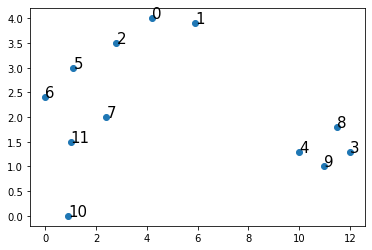

In [2]:
X = np.array([
    [4.2, 4.0], 
    [5.9, 3.9],
    [2.8, 3.5],
    [12.0, 1.3],
    [10.0, 1.3],
    [1.1, 3.0],
    [0.0, 2.4],
    [2.4, 2.0],
    [11.5, 1.8],
    [11.0, 1.0],
    [0.9, 0.0],
    [1.0, 1.5]
], np.single)

# X = StandardScaler().fit_transform(X)

# normalize vectors
X_norm = Normalizer().fit_transform(X)

# real clusters
y =  np.array([1, 0, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1])

fig, ax = plt.subplots()
for i, txt in enumerate(range(len(X))):
    ax.annotate(i, (X[i,0], X[i,1]), size=15)
ax.scatter(X[:,0], X[:,1]);

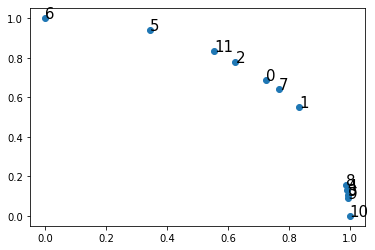

In [3]:
fig, ax = plt.subplots()
for i, txt in enumerate(range(len(X_norm))):
    ax.annotate(i, (X_norm[i,0], X_norm[i,1]), size=15)
ax.scatter(X_norm[:,0], X_norm[:,1]);

# Clusterization performance metrics

In [4]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
# from sklearn.metrics import pairwise_distance

# n_clusters: the number of discovered clusters,
# y: real clusters,
# c: discovered clusters

# Purity
def purity(C, G):
    common_items_inclusters = metrics.cluster.contingency_matrix(C, G)
    purity_score = np.sum(np.amax(common_items_inclusters, axis=0)) / np.sum(common_items_inclusters)
    return purity_score

def evaluate(y_pred, y_true, data):
    y_pred = cluster_encoder(y_pred)
    return {
        "purity": purity(y_true, y_pred),
        "adjusted_rand_score": adjusted_rand_score(y_true, y_pred),
        "davies_bouldin_score": davies_bouldin_score(data, y_pred),
        "silhouette_score_euclidean": metrics.silhouette_score(data, y_pred, metric = 'euclidean'),
        "silhouette_score_cosine": metrics.silhouette_score(data, y_pred, metric = 'cosine'),
    }

# Distance or (dis)similarity measures 

## Euclidean similarity

In [5]:
def euclidean_distance(a, b):
    similarity_measure = 0
    for i in range(len(a)):
         similarity_measure += pow((a[i] - b[i]), 2)
    return np.sqrt(similarity_measure)

## Cosinus dissimilarity 

In [6]:
def cosine_dissimilarity(a, b):
    dot = 0
    norm_a = 0
    norm_b = 0
    for i in range(len(a)):
        dot += a[i] * b[i]
        norm_a += a[i]**2
        norm_b += b[i]**2
    return 1 - dot / (norm_a * norm_b)**0.5

## Cosine similarity

In [7]:
def cosine_similarity(a, b):
    dot = 0
    norm_a = 0
    norm_b = 0
    for i in range(len(a)):
        dot += a[i] * b[i]
        norm_a += a[i]**2
        norm_b += b[i]**2
    return dot / (norm_a * norm_b)**0.5

In [89]:
# from numpy import dot
# from numpy.linalg import norm

def cosine_similaryty_numpy(a, b):
    return (a @ b.T) / (norm(a)*norm(b))

# DBSCAN

## Get reachable neighbors

In [8]:
def get_neighbors(X, current_index, epsilon, similarity):
    '''
    X - dataset with point coordinates,
    current_index - index of given point,
    epsilon - max similarity or distance to given point,
    similarity - metric of similarity or distance bewteen two points
    '''
    neighbor_indices = []
    for neighbor_index, neighbor in enumerate(X):
        if similarity(neighbor, X[current_index]) <= epsilon:
            neighbor_indices.append(neighbor_index)
    return neighbor_indices

## Clusterization algorithm

In [9]:
def dbscan(X, epsilon, minPts, similarity):
    '''
    X - dataset with point coordinates,
    epsilon - max similarity or distance to given point,
    minPts - minimum number of points that create cluster,
    similarity - metric of similarity or distance bewteen two points
    '''
    # each data point can be in one of 3 stages
    NOT_VISITED = 0 # not visited point
    VISTED = 1 # non-core point
    CLUSTERED = 2 # core point
    
    # initial setup
    n = X.shape[0]
    cluster = np.array([0] * n) # cluster register
    state = np.array([NOT_VISITED] * n) # state register
    cluster_id = 1

    def search(current_index, cluster_id, epsilon, minPts, similarity):
        neighbor_indices = get_neighbors(X, current_index, epsilon, similarity)
        if len(neighbor_indices) >= minPts:
            state[current_index] = CLUSTERED
            cluster[current_index] = cluster_id
            for neighbor_index in neighbor_indices:
                if state[neighbor_index] == NOT_VISITED:
                    state[neighbor_index] = CLUSTERED
                    cluster[neighbor_index] = cluster_id
                    search(neighbor_index, cluster_id, epsilon, minPts, similarity)
        else:
            state[current_index] = VISTED

    while NOT_VISITED in state:
        not_visited_ids = np.where(state==NOT_VISITED)[0]
        search(not_visited_ids[0], cluster_id, epsilon, minPts, similarity)
        cluster_id += 1
    
    return cluster

# DBSCAN-RN

## KNN

In [10]:
def get_knn(current_index, neighbor_indices, k, similarity, X):
    
    # Remove current point from neighbors
    if current_index in neighbor_indices: neighbor_indices.remove(current_index)
    
    # For each neighbor measure similarity to current point
    neighbor_similaritys = []
    for neighbor_index in neighbor_indices:
        similarity_measure = similarity(X[neighbor_index], X[current_index])
        neighbor_similaritys.append(similarity_measure) 
        
    # Get k-nearest neighbors
    sort_indices = np.argsort(neighbor_similaritys) # sort arguments and return indexes
    neighbor_indices = np.array(neighbor_indices) 
    return neighbor_indices[sort_indices][:k].tolist()

In [110]:
np.array([5,6,4])[np.argsort([5,6,4])]

array([4, 5, 6])

In [9]:
# # check
# all_point_indices = list(range(len(X)))
# for x in range(len(all_point_indices)):
#     print(x, get_knn(x, all_point_indices[:], 3, euclidean_distance, X))

## RNN

In [11]:
def get_pointwise_rnn(point_knn, current_index):
    rnn = []
    for neighbor in point_knn[current_index]:
        if current_index in point_knn[neighbor]:
            rnn.append(neighbor)
    return rnn
    
def get_rnn(point_indices, k, similarity, X):
    point_rnn = {}
    point_knn = {}
    for current_index in point_indices:
        knn = get_knn(current_index, point_indices[:], k, similarity, X)
        point_knn[current_index] = knn
    for current_index in point_indices:
        rnn = get_pointwise_rnn(point_knn, current_index)
        point_rnn[current_index] = rnn
    return point_rnn, point_knn

## TI-KNN

In [12]:
def check_pessimistic_estimation(df, df2, current_point):
    # calculate real distance to current point
    df2['real'] = df2.apply(lambda row: euclidean_distance(row[['x','y']], current_point[['x','y']].values[0]), axis=1)
    df.update(df2)
    # choose max real distance
    max_val = df2.max()
    # get points with fake distance below max real distance 
    return df[(df['pesimistic_distance'] < max_val['real']) & (df['pesimistic_distance'] > 1) & (df['real'].isna())]

In [13]:
all_point_indices = list(range(len(X_norm))) 
    
df = pd.DataFrame({
    "index": all_point_indices,
    "x": X_norm[all_point_indices][:,0],
    "y": X_norm[all_point_indices][:,1],
    'real': np.nan
})

k = 3

def ti_knn(k, df, current_index, all_point_indices):
   
    # calculate distance to reference point, [0,1]
    df['r_distnace'] = df.apply(lambda row: euclidean_distance(row[['x','y']], [0,1]), axis=1)
    df = df.sort_values(by='r_distnace')

    # calculate distance to current point
    current_point = df[df['index']==current_index]
    df['pesimistic_distance'] = abs(df['r_distnace'] - current_point['r_distnace'].values[0] )

    # get k-NN acording to pessimistic estimation 
    df2 = df[df['pesimistic_distance'] > 0].sort_values(by='pesimistic_distance').head(k)
    # was > 1, changed to > 0

    dfn = check_pessimistic_estimation(df, df2, current_point)

    # check if current df is empty
    def empty_df(df, df2, dfn):
        for n in range(0, df.shape[0]):
            if dfn.empty:
                result = df.sort_values(by='real').head(k) 
                return result
            else:
                dfn = check_pessimistic_estimation(df, dfn, current_point)
                empty_df(df, df2, dfn)

    result = empty_df(df, df2, dfn)
    df['real']=np.nan
    
    return result

In [14]:
def get_tiknn(k, df, all_point_indices):
    point_knn = {}
    for current_index in range(0, df.shape[0]):
        result = ti_knn(k, df, current_index, all_point_indices)
        point_knn_result = result['index'].to_list()
        point_knn_result = [int(point) for point in point_knn_result]
        point_knn[current_index] = point_knn_result
    return point_knn

## TI-RNN

In [15]:
def gert_tirnn(k, df, point_indices):
    point_tirnn = {}
    point_tiknn = get_tiknn(k, df, all_point_indices)
    for current_index in point_indices:
        rnn = get_pointwise_rnn(point_tiknn, current_index)
        point_tirnn[current_index] = rnn
        
    return point_tirnn, point_tiknn

## Clusterization algorithm

### DBSCANRN + classic KNN

In [16]:
def dbscanrn(X, k, similarity):
    
    # each X point can be in one of 3 stages
    NOT_VISITED = 0 # not visited point
    VISTED = 1 # non-core point
    CLUSTERED = 2 # core point
    
    # initial setup
    n = X.shape[0]
    cluster = np.array([0] * n) # cluster register
    state = np.array([NOT_VISITED] * n) # state register
    cluster_id = 1
    all_point_indices = list(range(len(X))) # inidces of all points
    point_rnn, point_knn = get_rnn(all_point_indices, k, similarity, X) # calculate RNN_k for all points
    
    # search for clusters
    def search(current_index, k):
        if len(point_rnn[current_index]) < k:
                state[current_index] = VISTED
        else:
            state[current_index] = CLUSTERED
            cluster[current_index] = cluster_id
            for neighbor_index in point_rnn[current_index]:
                if state[neighbor_index] == NOT_VISITED:
                    search(neighbor_index, k)
                state[neighbor_index] = CLUSTERED
                cluster[neighbor_index] = cluster_id
                    
    # visit all X points
    while NOT_VISITED in state:
        not_visited_ids = np.where(state==NOT_VISITED)[0][0]
        search(not_visited_ids, k)
        cluster_id += 1
    
    # clusterize all outlier data points 
    while VISTED in state:
        not_clustered_ids = np.where(state==VISTED)[0][0]
        clustered_ids = np.where(state==CLUSTERED)[0]
        knn = get_knn(not_clustered_ids, clustered_ids, 1, similarity, X)
        cluster[not_clustered_ids] = cluster[knn[0]]
        state[not_clustered_ids] = CLUSTERED
    
    return cluster

### DBSCANRN + ti-KNN

In [17]:
def ti_dbscanrn(X, k, similarity):
    
    # each X point can be in one of 3 stages
    NOT_VISITED = 0 # not visited point
    VISTED = 1 # non-core point
    CLUSTERED = 2 # core point
    
    # initial setup
    n = X.shape[0]
    cluster = np.array([0] * n) # cluster register
    state = np.array([NOT_VISITED] * n) # state register
    cluster_id = 1
    all_point_indices = list(range(len(X))) # inidces of all points
    point_rnn, point_knn = gert_tirnn(k, df, all_point_indices) # calculate RNN_k for all points
    
    # search for clusters
    def search(current_index, k):
        if len(point_rnn[current_index]) < k:
                state[current_index] = VISTED
        else:
            state[current_index] = CLUSTERED
            cluster[current_index] = cluster_id
            for neighbor_index in point_rnn[current_index]:
                if state[neighbor_index] == NOT_VISITED:
                    search(neighbor_index, k)
                state[neighbor_index] = CLUSTERED
                cluster[neighbor_index] = cluster_id
                    
    # visit all X points
    while NOT_VISITED in state:
        not_visited_ids = np.where(state==NOT_VISITED)[0][0]
        search(not_visited_ids, k)
        cluster_id += 1
    
    # clusterize all outlier data points 
    while VISTED in state:
        not_clustered_ids = np.where(state==VISTED)[0][0]
        clustered_ids = np.where(state==CLUSTERED)[0]
        knn = get_knn(not_clustered_ids, clustered_ids, 1, similarity, X)
        cluster[not_clustered_ids] = cluster[knn[0]]
        state[not_clustered_ids] = CLUSTERED
    
    return cluster

# Evaluation

## DBSCAN

### DBSCAN: euclidean distance

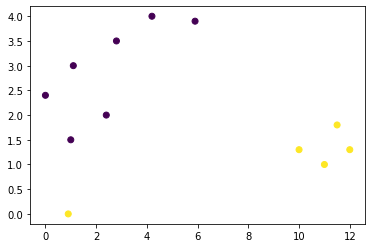

{'purity': 0.8333333333333334,
 'adjusted_rand_score': 0.5097493036211699,
 'davies_bouldin_score': 0.7589424132751467,
 'silhouette_score_euclidean': 0.50847596,
 'silhouette_score_cosine': 0.76168364}

In [18]:
y_pred = dbscan(X=X_norm, epsilon=0.42, minPts=3, similarity=euclidean_distance)

# display results
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X)

### DBSCAN: cosine dissimilarity

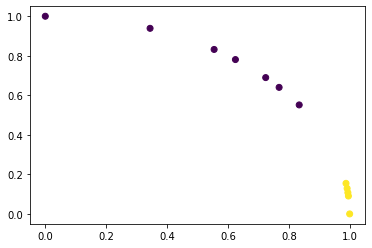

{'purity': 0.8333333333333334,
 'adjusted_rand_score': 0.5097493036211699,
 'davies_bouldin_score': 0.36743682429155733,
 'silhouette_score_euclidean': 0.6683597,
 'silhouette_score_cosine': 0.76168364}

In [28]:
y_pred = dbscan(X=X_norm, epsilon=0.07, minPts=3, similarity=cosine_dissimilarity)

# display results
fig, ax = plt.subplots()
ax.scatter(X_norm[:,0], X_norm[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X_norm)

## DBSCAN: cosine similarity

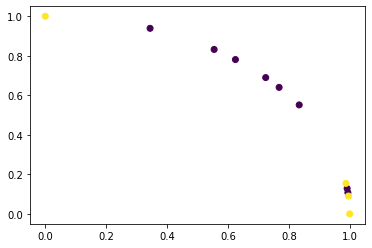

{'purity': 0.5833333333333334,
 'adjusted_rand_score': -0.0547945205479452,
 'davies_bouldin_score': 2.969022389089624,
 'silhouette_score_euclidean': 0.15740474,
 'silhouette_score_cosine': 0.18675934}

In [90]:
y_pred = dbscan(X=X_norm, epsilon=0.2, minPts=3, similarity=cosine_similarity)

# display results
fig, ax = plt.subplots()
ax.scatter(X_norm[:,0], X_norm[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X_norm)

## DBSCANRN

### DBSCANRN: euclidean distance + classic KNN

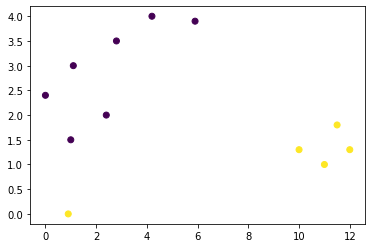

{'purity': 0.8333333333333334,
 'adjusted_rand_score': 0.5097493036211699,
 'davies_bouldin_score': 0.7589424132751467,
 'silhouette_score_euclidean': 0.50847596,
 'silhouette_score_cosine': 0.76168364}

In [64]:
y_pred = dbscanrn(X=X_norm, k=3, similarity=euclidean_distance)

# display results
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X)

### DBSCANRN: cosine dissimilarity + classic KNN

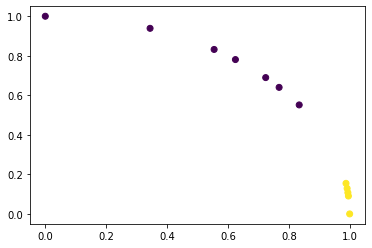

{'purity': 0.8333333333333334,
 'adjusted_rand_score': 0.5097493036211699,
 'davies_bouldin_score': 0.36743682429155733,
 'silhouette_score_euclidean': 0.6683597,
 'silhouette_score_cosine': 0.76168364}

In [65]:
y_pred = dbscanrn(X=X_norm, k=4, similarity=cosine_dissimilarity)

# display results
fig, ax = plt.subplots()
ax.scatter(X_norm[:,0], X_norm[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X_norm)

### DBSCANRN: cosine similarity + classic KNN

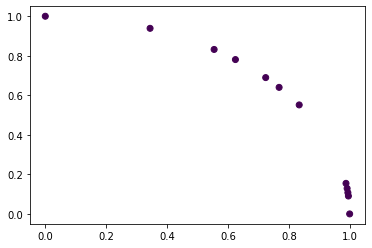

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [100]:
y_pred = dbscanrn(X=X_norm, k=4, similarity=cosine_similarity)

# display results
fig, ax = plt.subplots()
ax.scatter(X_norm[:,0], X_norm[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X_norm)

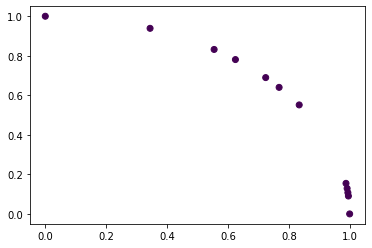

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [96]:
y_pred = dbscanrn(X=X_norm, k=4, similarity=cosine_similaryty_numpy)

# display results
fig, ax = plt.subplots()
ax.scatter(X_norm[:,0], X_norm[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X_norm)

### DBSCANRN: euclidean distance + ti-KNN

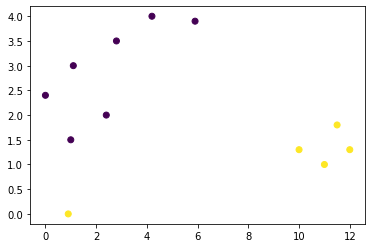

{'purity': 0.8333333333333334,
 'adjusted_rand_score': 0.5097493036211699,
 'davies_bouldin_score': 0.7589424132751467,
 'silhouette_score_euclidean': 0.50847596,
 'silhouette_score_cosine': 0.76168364}

In [74]:
y_pred = ti_dbscanrn(X=X_norm, k=2, similarity=euclidean_distance)

# display results
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X)

### DBSCANRN: cosine dissimilarity + ti-KNN

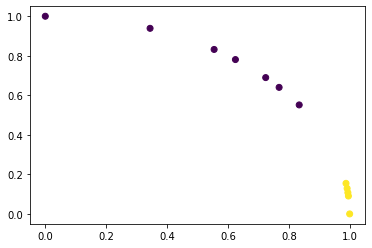

{'purity': 0.8333333333333334,
 'adjusted_rand_score': 0.5097493036211699,
 'davies_bouldin_score': 0.36743682429155733,
 'silhouette_score_euclidean': 0.6683597,
 'silhouette_score_cosine': 0.76168364}

In [75]:
y_pred = ti_dbscanrn(X=X_norm, k=2, similarity=cosine_dissimilarity)

# display results
fig, ax = plt.subplots()
ax.scatter(X_norm[:,0], X_norm[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X_norm)

### DBSCANRN: cosine similarity + ti-KNN

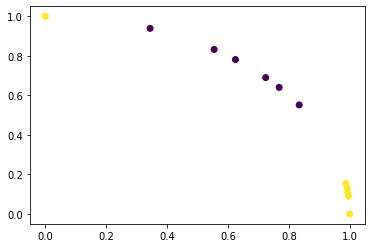

{'purity': 0.75,
 'adjusted_rand_score': 0.2913165266106443,
 'davies_bouldin_score': 1.0481691108966802,
 'silhouette_score_euclidean': 0.5012502,
 'silhouette_score_cosine': 0.49780026}

In [82]:
y_pred = ti_dbscanrn(X=X_norm, k=4, similarity=cosine_similarity)

# display results
fig, ax = plt.subplots()
ax.scatter(X_norm[:,0], X_norm[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X_norm)

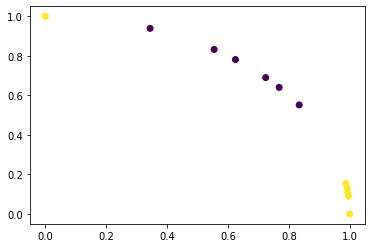

{'purity': 0.75,
 'adjusted_rand_score': 0.2913165266106443,
 'davies_bouldin_score': 1.0481691108966802,
 'silhouette_score_euclidean': 0.5012502,
 'silhouette_score_cosine': 0.49780026}

In [97]:
y_pred = ti_dbscanrn(X=X_norm, k=4, similarity=cosine_similaryty_numpy)

# display results
fig, ax = plt.subplots()
ax.scatter(X_norm[:,0], X_norm[:,1], c=y_pred)
plt.show()

# evaluation
evaluate(y_pred, y, X_norm)